# Demo: Tool to Analyze UFS Input & Baseline Datasets

### __Purpose:__ 

The purpose of the tool is to extract additional information regarding the input and baseline datasets residing within the RDHPCS -- in an effort to assist NOAA in the cleaning & restructuring of the current UFS data structure. In this demontration, the tool will be applied against the UFS input and baseline datasets residing within the RDHPC platform, Orion.

### __Capabilities:__ 

The tool will be able to perform the following actions:

- Apply feature engineering to obtain additional information regarding the data files. 
  
- Extract all data filenames mapping them to their corresponding relative directory path, 
  root folder, filename, filesize, file format, compiler (if applicable), CNTL folder (if applicable),
  "input" or "restart" file type, resolution (km) category, resolution (C resolution) category. 
  
- Analyze & plot the current storage size of each UFS data file per timestamp per dataset type (input, baseline). 
  Note: At the time at which the tool is being executed, it will extract the data information from the RDHPC
  platform at that time. Thus, the data information of the datasets residing within the RDHPC will be dynamic 
  as the datasets are being cleaned.
  
- Extract number of nodes ("folders") per file to assist in categorization of the folders -- currently, node levels vary.
- Confirm no input data files are being duplicated per UFS Component's root folder and per CNTL folder.
- Categorize, sort by feature, & write restructuring data table to csv file.

### __Future Capabilities:__  
- This tool can be used as a skeleton framework for acquiring additional information regarding the data analytics of future datasets of interest (e.g. SRW data, MRW data, etc).
- Construct the hierarchical trees for each unique dataset residing within a RDHPC platform.

### __Procedural Steps to Utilize Data Analytics Tool:__

#### ___Environment Setup___

1.	Install miniconda on your machine. Note: Miniconda is a smaller version of Anaconda that only includes conda along with a small set of necessary and useful packages. With Miniconda, you can install only what you need, without all the extra packages that Anaconda comes packaged with:

Download latest Miniconda (e.g. 3.9 version):
__wget https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh__

Check integrity downloaded file with SHA-256:
__sha256sum Miniconda3-py39_4.9.2-Linux-x86_64.sh__

Reference SHA256 hash in following link: https://docs.conda.io/en/latest/miniconda.html

Install Miniconda in Linux:
__bash Miniconda3-py39_4.9.2-Linux-x86_64.sh__

Next, Miniconda installer will prompt where do you want to install Miniconda. Press ENTER to accept the default install location i.e. your $HOME directory. If you don't want to install in the default location, press CTRL+C to cancel the installation or mention an alternate installation directory. If you've chosen the default location, the installer will display “PREFIX=/var/home/<user>/miniconda3” and continue the installation.

For installation to take into effect, run the following command: 
__source ~/.bashrc__

You will now see the prefix (base) in front of your shell prompt. It means that the conda's base environment is activated.

2.	Once you have conda installed on your machine, perform the following to create a conda environment:

    - To rely on the base Miniconda installation:
    __conda create -n [Name of your conda environment you wish to create]__
    
    (or)

    - To ensure you are running Python 3.9:
    __conda create -n myenv Python=3.9__

From now on, you have to manually activate conda environment using command: __$ conda activate__
To deactivate conda environment: __$ conda deactivate__


3.	A .yml file is a text file that contains a list of dependencies, which channels a list for installing dependencies. To build the created conda environment from YAML file execute __conda env create -f environment.yml__

__*Note:__ For the code to utilize the dependencies, you will need to be in the directory where the environment.yml file lives.

4.	Activate the new environment via: 
__conda activate [Name of your conda environment you wish to activate]__

5.	Verify that the new environment was installed correctly via:
__conda info –envs__


#### ___Link Home Directory to Dataset Location on RDHPCS Platform___ 
6.	Unfortunately, there is no way to navigate to the /work/ filesystem from within the Jupyter interface. The best way to workaround is to create a symbolic link in your home folder that will take you to the /work/ filesystem. Run the following command from a linux terminal on Orion to create the link: 

__ln -s /work /home/[Your user account name]/work__

Now, when you navigate to the /home/[Your user account name]/work directory in Jupyter, it will take you to the /work/ directory. Allowing you to obtain any data in the /work/ filesystem that you have permission to access from Jupyter. This same procedure will work for any filesystem available from the root directory. 

__Note:__ On Orion, user must sym link from their home directory to the main directory containing the datasets of interest.

___Open & Run Data Analytics Tool on Jupyter Notebook___
7.	Open OnDemand has a built-in file explorer and file transfer application available directly from its dashboard via ...
    - Login to https://orion-ood.hpc.msstate.edu/ 
    - In the Open OnDemand Interface, select __Interactive Apps__ > __Jupyter Notbook__
    - Set the following configurations to run Jupyter:


#### ___Additonal Information:___

__To create a .yml file__

- Activate the environment to export: 
__conda activate myenv__

- Export your active environment to a new file:
__conda env export > environment.yml__


### __Reference(s):__
- Latest UFS Weather Model Guide:
    - https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html


In [ ]:
import os
from pathlib import Path
import re
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

class read_data_dirs():
    """
    Extracts all data (residing on a RDHPCS) filenames & map them to their corresponding 
    directories. Applies feature engineering and analyzes the current data structure of the datasets
    being utilized for the UFS weather model repository. Note: Can be modified for 
    the data analytics of future datasets of interest (e.g. SRW data, MRW data, etc). 
    
    """
    def __init__(self, hpc_dir, avoid_fldrs):
        
        # Datasets' main directory of interest. 
        self.hpc_dir = hpc_dir
        
        # Extracts all directories residing w/in datasets' main directory of interest. 
        # Remove file directories comprise of a folder name.
        self.avoid_fldrs = avoid_fldrs
        self.file_dirs = self.get_data_dirs()
        
        # List of all directories w/in the input & baseline datasets.
        self.input_dirs, self.baseline_dirs = self.get_input_bl_data()
        
        # File size.
        self.input_filesize = self.get_filesize("input")
        self.baseline_filesize = self.get_filesize("baseline")
        
        # List of all data folders/files in datasets' main directory of interest.
        print("\033[1m" +\
              f"All Primary Dataset Folders & Files In Main Directory ({self.hpc_dir}):" +\
              f"\n\n\033[0m{os.listdir(self.hpc_dir)}")
        
    def get_data_dirs(self):
        """
        Extract list of all file directories in datasets' main directory.
        
        Args:
            None
            
        Return (list): List of all file directories in datasets' main directory
        of interest.
        
        """
        
        # Generate list of all file directories residing w/in datasets' 
        # main directory of interest. 
        file_dirs = []
        file_size =[]
        for root_dir, subfolders, filenames in os.walk(self.hpc_dir):
            for file in filenames:
                file_dirs.append(os.path.join(root_dir, file))
        
        # Removal of personal names.
        if self.avoid_fldrs != None:
            file_dirs = [x for x in file_dirs if any(x for name in self.avoid_fldrs if name not in x)]
        
        return file_dirs

    def get_input_bl_data(self):
        """
        Extract list of all input file & baseline file directories.

        Args: 
            None
            
        Return (list, list): List of all input file & baseline file directories.

        """
        input_dirs = []
        baseline_dirs = []
        for file_dir in self.file_dirs:

            # Input data files w/ root directory truncated.
            if any(subfolder in file_dir for subfolder in ['input-data']):
                input_dirs.append(file_dir.replace(self.hpc_dir, ""))

            # Baseline data files w/ root directory truncated.
            if any(subfolder in file_dir for subfolder in ['develop', 'ufs-public-release']):
                baseline_dirs.append(file_dir.replace(self.hpc_dir, ""))

        return input_dirs, baseline_dirs    
    
    def get_filesize(self, dataset_type):
        """
        Extracts storage size for each data file located in either input or baseline datasets.
        
        Args:
            dataset_type (str): The dataset type ("input" or "baseline") of interest to
                                obtain list of filesizes.
            
        Return (list): List of each file's storage size residing in either input or basline datasets. 
        
        """
        
        # Set dataset type to obtain dataset type's list of file directories.
        filesize_list = []
        if dataset_type == 'input':
            dir_list = self.input_dirs
        if dataset_type == 'baseline':
            dir_list = self.baseline_dirs
        
        # Extract size of each file. 
        for file_dir in dir_list:
            filesize_list.append(Path(self.hpc_dir + file_dir).stat().st_size)

        return filesize_list
    
    def get_resolutions(self, file_df):
        """
        Extract resolutions based on relative directory path.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory' (mention of resolution values).

        Return (pd.DataFrame): A dataframe w/ resolution in C and km format appended. 
        
        Note: Method is called by "preprocess_dirs," but can be applied to any dataframe
        w/ at least the following feature: 'Relative Directory' (mention of resolution
        values).
        
        """
        
        # Map C resolution & Km annotation to Km format.
        map_res = {48: 200, 96: 100, 192: 50, 384: 25, 768: 13, 1536: 6.5, 3072: 3.25, 
                   '400': 400, '200': 200, '100': 100, '050': 50, '025': 25, '13km': 13}

        # Map Km & C resolution annotation to C resolution format.
        map_cres = {'400': 24, '200': 48, '100': 96, '050': 192, '025': 384, '13km': 768,
                     48: 48, 96: 96, 192: 192, 384: 384, 768: 768, 1536: 1536, 3072: 3072}
        res_list = []
        cres_list = []
        for idx, row in file_df.iterrows():

            if '3072x1536' in row['Relative Directory']:
                res_list.append(np.nan)
                cres_list.append(np.nan)
            elif '768' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res[768])
                cres_list.append(map_cres[768])
            elif '384' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res[384])
                cres_list.append(map_cres[384])
            elif '192' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res[192])
                cres_list.append(map_cres[192])
            elif '96' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res[96])
                cres_list.append(map_cres[96])
            elif '48' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res[48])
                cres_list.append(map_cres[48])
            elif '025' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res['025'])
                cres_list.append(map_cres['025'])
            elif '050' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res['050'])
                cres_list.append(map_cres['050'])
            elif '400' in row['Relative Directory'] and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res['400'])
                cres_list.append(map_cres['400'])
            elif '13km' in row['Relative Directory']:
                res_list.append(map_res['13km'])
                cres_list.append(map_cres['13km'])        
            elif '100' in row['Relative Directory']  and 'CPL_FIX/aC' not in row['Relative Directory']:
                res_list.append(map_res['100'])
                cres_list.append(map_cres['100'])
            else:
                res_list.append(np.nan)
                cres_list.append(np.nan)
    
        # Append resolution formats to preprocessing dataframe of interest.
        file_df['Res (C)'] = cres_list
        file_df['Res (km)'] = res_list

        return file_df
    
    def get_data_component(self, file_df):
        """
        Extract data component name based on files' relative directory paths.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory' (mention of UFS component).

        Return (pd.DataFrame): A dataframe w/ UFS component name appended.
        
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Relative Directory' (mention 
        of UFS component).
        
        """
        
        # Extract data component name.
        data_cat = []
        for idx, row in file_df.iterrows():
            if 'FV3_hafs' in row['Relative Directory']:
                data_cat.append("FV3_HAFS")
            elif 'FV3_regional' in row['Relative Directory']:
                data_cat.append("FV3_REGIONAL")
            elif 'fv3_regional' in row['Relative Directory']:
                data_cat.append("FV3_REGIONAL")
            elif 'FV3_hafs_regional' in row['Relative Directory']:
                data_cat.append("FV3_HAFS_REGIONAL")
            elif 'FV3' in row['Relative Directory']:
                data_cat.append("FV3")
            elif 'MOM6' in row['Relative Directory']:
                data_cat.append("MOM6")   
            elif 'HYCOM_regional' in row['Relative Directory']:
                data_cat.append("HYCOM_REGIONAL")
            elif 'HYCOM' in row['Relative Directory']:
                data_cat.append("HYCOM") 
            elif 'CICE' in row['Relative Directory']:
                data_cat.append("CICE")
            elif 'WW3' in row['Relative Directory']:
                data_cat.append("WW3")
            elif 'CDEPS_ATM' in row['Relative Directory']:
                data_cat.append("CDEPS_ATM")
            elif 'CDEPS_OCEAN' in row['Relative Directory']:
                data_cat.append("CDEPS_OCEAN")
            elif 'DATM' in row['Relative Directory']:
                data_cat.append("DATM")
            elif 'DATM_CDEPS' in row['Relative Directory']:
                data_cat.append("CDEPS_DATM")
            elif 'CPL' in row['Relative Directory']:
                data_cat.append("CPL")
            elif 'GOCART' in row['Relative Directory']:
                data_cat.append("GOCART")
            else:
                data_cat.append(np.nan)
                
        # Append resolution formats to preprocessing dataframe of interest.        
        file_df['UFS Component'] = data_cat

        return file_df
    
    def input_or_restart(self, file_df):
        """
        Confirm all "input" or "restart" data files are in accordance to the UFS guide.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory.'

        Return (pd.DataFrame): A dataframe w/ the classification of a 
        file being a "input" or "restart" file appended.
        
        - Categorization is based on the UFS guide can be found in the following
        link: https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html.
        To classify a data file as being an "input" file, analysis was performed 
        to determine the UFS Guide I/O section list of input files matched up w/
        the input files residing in the RDHPC datasets. During the analysis, the
        files listed in the UFS Guide I/O section list of input files per
        UFS component were located in "file_df" & their directories (shown below)
        were captured.
        
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Relative Directory.'
                
        **Follow-up on 020122 w/ NOAA (Denise W. & Jun W.):**
        - According to the guide, "No fix files are required for CICE6," 
        however there is a "CICE_FIX" folder. [Follow-up on 020122: Discussion w/ 
        NOAA, confirmed the files in "CICE_FIX" folder does not
        follow the UFS Guide. Thus, its foldername could be subject to change -- in
        an effort to maintain data structure consistency & comply with the UFS 
        Guide's definition of static ("fix") files.]
        
        **TODO:** 
        - Need to acquire the GOCART I/O list of files for confirmation on 
        its categorization.
        
        """
        
        # Input data folders per UFS component.
        fv3_input_folders = ['/FV3_fix', '/FV3_fix_tiled', '/FV3_hafs_input_data', 
                             'FV3_input_data_C96_with_aerosols', 'FV3_input_data',
                             '/FV3_regional_input_data', '/FV3_input_data_regional_esg',
                             '/FV3_input_data_gsd', 'FV3_input_frac', 'FV3_input_data_L149',
                             '/INPUT', 'ORO_FLAKE', 'FV3_input_data192', 'FV3_input_data384',
                             'FV3_input_data48', 'FV3_input_data768', '/FV3_nest_input_data',
                             '/FV3_hafs_regional_input_data']
        mom6_input_folders = ['/MOM6_FIX', '/MOM6_IC']
        hycom_input_folders = ['/HYCOM_regional_input_data']
        cice6_input_folders = ['/CICE_FIX', '/CICE_IC']
        ww3_input_folders = ['/WW3_input_data'] # ensure this is captured
        cdeps_atm_input_folders = ['/DATM_CDEPS/CFSR', '/DATM_CDEPS/GEFS',
                                   '/DATM_ERA5_input_data', '/DATM/CFSR/',
                                   '/DATM/GEFS/', '/DATM_CDEPS/CFSR3072x1536/201110',
                                   '/DATM']
        cdeps_ocean_input_folders = ['DOCN_OISST_input_data', 'DOCN_MOM6_input_data']
        cpl_input_folders = ['/CPL_FIX']
        gocart_input_folders = ['/GOCART']
        all_input_folders = fv3_input_folders + mom6_input_folders + hycom_input_folders +\
                            cice6_input_folders + ww3_input_folders +\
                            cdeps_atm_input_folders + cdeps_ocean_input_folders +\
                            cpl_input_folders + gocart_input_folders
        
        # Extract classification status based on the folders containing "input" files
        # & files residing w/in a restart (/RESTART) folder.
        data_cat = []
        for idx, row in file_df.iterrows():
            if any(folder in row['Relative Directory'] for folder in all_input_folders):
                data_cat.append("input")
            elif '/RESTART' in row['Relative Directory']:
                data_cat.append("restart")
            else:
                data_cat.append(np.nan)
        
        # Append classification status to preprocessing dataframe of interest.     
        file_df['input_or_restart'] = data_cat

        return file_df
    
    def get_datatype(self, file_df):
        """
        Extract each data file's format.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Filename.'
                                    
        Return (pd.DataFrame): A dataframe w/ each data file's format appended. 
                
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Filename.'
        
        """
        data_type = []
        for idx, row in file_df.iterrows():
            if row['Filename'].endswith('.nc1'):
                data_type.append("nc1")
            elif row['Filename'].endswith('.nc4'):
                data_type.append("nc4")
            elif row['Filename'].endswith('.nc'):
                data_type.append("nc")
            elif row['Filename'].endswith('.grb'):
                data_type.append("grib")
            elif '.Grb' in row['Filename']:
                data_type.append("grib")
            elif row['Filename'].endswith('.txt'):
                data_type.append("txt")
            elif row['Filename'].endswith('.f77'):
                data_type.append("f77")
            elif row['Filename'].endswith('nml'):
                data_type.append("nml")
            elif row['Filename'].endswith('.dat'):
                data_type.append("dat")
            elif row['Filename'].endswith('.md5'):
                data_type.append("md5")
            elif row['Filename'].endswith('.md'):
                data_type.append("md")
            elif row['Filename'].endswith('.rc'):
                data_type.append("rc")
            elif row['Filename'].endswith('.res'):
                data_type.append("res")
            elif row['Filename'].endswith('.a'):
                data_type.append("32-bit IEEE data")
            elif row['Filename'].endswith('.b'):
                data_type.append("plain text metadata")
            elif row['Filename'].endswith(tuple(['.SH','.sh'])):
                data_type.append("shell")
            elif row['Filename'].endswith(tuple(['.TBL','.tbl'])):
                data_type.append("table")
            elif row['Filename'].endswith(tuple(['.BIN','.bin'])):
                data_type.append("binary")
            elif row['Filename'].endswith('.ww3'):
                data_type.append("ww3 binary")
            elif row['Filename'].endswith('.ncl'):
                data_type.append("ncl")
            else:
                data_type.append(np.nan)
        
        # Append data file formats to preprocessing dataframe of interest. 
        file_df['DataType'] = data_type
        
        return file_df
    
    def get_nodes_feats(self, file_df):
        """
        Extract & partition subfolders into features.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory.'

        Return (pd.DataFrame):  A dataframe w/ each data files' subfolder/node
        partitioned into features.
        
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Relative Directory.'

        """
        # Extract number of nodes relative to main directory.
        file_df['Nodes Relative to Main'] = file_df['Relative Directory'].str.count("/") + 1

        # Extract & partition relative directory into sub-directories.
        folder_columns_df = file_df['Relative Directory'].str.split('/',expand=True)
        lst = range(len(folder_columns_df.columns))
        folder_columns_df.columns = [f"Node{format(x,'d')}" for x in lst]

        # Append subdirectories/node feature columns.
        file_df = pd.concat([file_df, folder_columns_df], axis=1)

        return file_df
    
    def get_couple_res(self, dir_df):
        """
        Extract the coupled resolution of coupled data files.
        
        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory.'
                                    
        Return (pd.DataFrame): A dataframe w/ coupled resolution of data files appended.
        
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Relative Directory.'

        """
        couple_res_list = []
        for idx, row in dir_df.iterrows():
            if 'CPL_FIX/aC' in row['Relative Directory']:
                rel_dir = row['Relative Directory']
                atm_res = rel_dir[rel_dir.find('/a') + 1 : rel_dir.find('o')]
                ocean_res = rel_dir[rel_dir.find('o') + 1 :]
                couple_res_list.append(atm_res + 'o' + ocean_res)
            else:
                couple_res_list.append(np.nan)
        dir_df['Couple Res']= couple_res_list    
        
        return dir_df
    
    def cat_restart4baseline(self, file_df):
        """
        Confirm all "input" or "restart" data files are in accordance to the UFS guide.

        Args:
            file_df (pd.DataFrame): A dataframe w/ at least the following feature:
                                    'Relative Directory.'

        Return (pd.DataFrame): A dataframe w/ the classification of a 
        file being a "input" or "restart" file appended.
        
        - Categorization is based on the UFS guide can be found in the following
        link: https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html.
        To classify a data file as being an "input" file, analysis was performed 
        to determine the UFS Guide I/O section list of input files matched up w/
        the input files residing in the RDHPC datasets. During the analysis, the
        files listed in the UFS Guide I/O section list of input files per
        UFS component were located in "file_df" & their directories (shown below)
        were captured.
        
        Note: Method is called by "preprocess_dirs," but can be applied to any 
        dataframe w/ at least the following feature: 'Relative Directory.'
        
        **TODO:** 
        - Need to acquire the Baseline datasets details for confirmation on 
        its categorization.
        
        """
        
        # Extract classification status based on files residing w/in a restart (/RESTART) folder.
        data_cat = []
        for idx, row in file_df.iterrows():
            if '/RESTART' in row['Relative Directory']:
                data_cat.append("restart")
            else:
                data_cat.append(np.nan)
        
        # Append classification status to preprocessing dataframe of interest.     
        file_df['input_or_restart'] = data_cat

        return file_df

    def preprocess_dirs(self, dir_list, dataset_type):
        """
        Apply feature engineering, preprocess & categorize the "input" or "baseline" dataset files.
        
        Args:
            dir_list (list): List of either input or baseline directories 
                             (w/ root directory truncated).
            dataset_type (str): The dataset type ("input" or "baseline") to
                                extract features & preprocess.
            
        Return (pd.DataFrame): A dataframe comprised of the filenames & its newly created 
        features for the given dataset type. Some of the new features will reveal each data
        file's root folder, filename, filesize, file format, compiler (if applicable), 
        CNTL folder (if applicable), "input" or "restart" file type, resolution (km) category,
        resolution (C resolution) category. 
        
        """
        # Extract subdirectories.
        dirs_tokens = [name.split("/") for name in dir_list]
        sub_folders = ['/'.join(x[:-1]) for x in dirs_tokens]

        # Extract filenames.
        filenames = [os.path.basename(x) for x in dir_list]
        
        # Extract UFS component name, CNTL folder name, filesize, & relevant compiler.
        if dataset_type == 'input':
            root_folder = [x[1:2][0] for x in dirs_tokens]
            filesize = self.input_filesize
            fn2dir = {'Root Folder': root_folder, 
                      'Relative Directory': sub_folders,
                      'Filename': filenames,
                      'Size': filesize}
        if dataset_type == 'baseline':
            cntl_folders = [x[2:3][0] for x in dirs_tokens]
            filesize = self.baseline_filesize
            compiler = [x[1:2][0] for x in dirs_tokens]
            fn2dir = {'CNTL Folder': cntl_folders, 
                      'Compiler': compiler, 
                      'Relative Directory': sub_folders, 
                      'Filename': filenames, 
                      'Size': filesize}
       
        # Generate & preprocess dataframe containing new features describing the dataset of interest.
        dir_df = pd.DataFrame(fn2dir)

        # Extract & append each dataset's timestamped date to dataframe.
        dir_df['Date'] = dir_df['Relative Directory'].apply(lambda x: re.search(r'\d{4}\d{2}\d{2}', x).group())
        dir_df.insert(0, 'Date', dir_df.pop('Date'))
        
        # Extract & append each file's resolutions (C & km formatted) to dataframe.
        dir_df = self.get_resolutions(dir_df)
        
        # Extract the coupled resolution of coupled data files.
        dir_df = self.get_couple_res(dir_df)

        # Extract & append each file's format to dataframe.
        dir_df = self.get_datatype(dir_df)
        
        # Extract additional features for the input dataset & append to dataframe.
        if dataset_type == 'input':

            # Extract & append UFS component name based on rel. directory.
            dir_df = self.get_data_component(dir_df)

            # Extract & append of "input" and "restart" status of each file for confirmation.
            dir_df = self.input_or_restart(dir_df)   
            
        # Extract additional features for the baseline dataset & append to dataframe.    
        if dataset_type == 'baseline': 
            # Extract & append of "input" and "restart" status of each file for confirmation.
            dir_df = self.cat_restart4baseline(dir_df)
            
        # Extract & append subdirectories/node features.
        dir_df = self.get_nodes_feats(dir_df)           
            
        # Save preprocessed dataframe as a pickle file.        
        self.save2pickle(dir_df, f'{dataset_type}_df')
        
        return dir_df
    
    def get_freq_files(self, input_df, ts_date):
        """
        Extract filenames that occur more than once under a given timestamp & root folder.

        Args:
            input_df (pd.DataFrame):
            ts_date (str): Timestamp to filter input datasets or None if no filtering of input
            datasets by timestamp.

        Return (pd.DataFrame): Generate dataframe containing only unique files which occur more than once
        # under a given timestamp' root folder. 

        """

        # Extract count of each file per date per root folder.
        file_freq_in_root = pd.DataFrame(input_df.groupby(['Date', 'Root Folder', 'Filename'])['Filename'].count())
        file_freq_in_root.columns = ['Occurence in Root Folder']

        ## Filter to files which occur more than once under a given timestamp' root folder.
        # **NOTE: Expect to see tiles given the various levels of subfolders per root folder.
        # Focus is on the static files that were repeating
        file_freq_in_root = file_freq_in_root[file_freq_in_root['Occurence in Root Folder']>1]

        # Extract list of unique files which occur more than once under a given 
        # timestamp's root folder.
        multiple_files_in_root = []
        for file in set(file_freq_in_root.index.get_level_values('Filename')):
            multiple_files_in_root.append(file)

        # Generate dataframe containing only unique files which occur more than once
        # under a given timestamp' root folder. 
        mult_files_df = input_df[input_df['Filename'].isin(multiple_files_in_root)]
        if ts_date != None:
            mult_files_df = mult_files_df[mult_files_df['Date'] == ts_date] #'20211210', '20211203'
        else:
            ts_date ='Overall'
        mult_files_df = mult_files_df[mult_files_df.duplicated(['Root Folder','Filename','Size'],\
                                                                 keep=False)].sort_values(['Root Folder',\
                                                                                           'Filename',\
                                                                                           'Size'],\
                                                                                           ascending=True)

        # Save dataframe of unique files which occur more than once to csv.
        mult_files_df.to_csv(f'Multiple_Files_In_Root_{ts_date}.csv', index = False)

        return mult_files_df
    
    def get_freq_files(self, data_df, ts_date, dataset_type):
        """
        Extract filenames occuring more than once under a given dataset type, timestamp, & root/CNTL folder.

        Args:
            data_df (pd.DataFrame): Dataframe of the input or baseline datasets w/ at least the 
                                    following features: "Filename", "Date", "Size" & "Root Folder" 
                                    or "CNTL Folder."
            ts_date (str): Timestamp to filter input datasets or None if no filtering of input
                           datasets by timestamp.
            dataset_type (str): "input" or "baseline" dataset type of "data_df."

        Return (pd.DataFrame): Generate dataframe containing only unique files which occur more than once
        # under a given timestamp' root folder. 

        """
        
        # Define dataset's type of main folder (Root vs CNTL).
        if dataset_type == 'input':
            main_folder4cat = 'Root Folder'
        if dataset_type == 'baseline':
            main_folder4cat = 'CNTL Folder'

        # Extract count of each file per date per root folder.
        file_freq_in_root = pd.DataFrame(data_df.groupby(['Date', main_folder4cat, 'Filename'])['Filename'].count())
        file_freq_in_root.columns = [f'Occurence in {main_folder4cat}']

        ## Filter to files which occur more than once under a given timestamp' root folder.
        # **NOTE: Expect to see tiles given the various levels of subfolders per root folder.
        # Focus is on the static files that were repeating
        file_freq_in_root = file_freq_in_root[file_freq_in_root[f'Occurence in {main_folder4cat}']>1]

        # Extract list of unique files which occur more than once under a given 
        # timestamp's root folder.
        multiple_files_in_root = []
        for file in set(file_freq_in_root.index.get_level_values('Filename')):
            multiple_files_in_root.append(file)

        # Generate dataframe containing only unique files which occur more than once
        # under a given timestamp' root folder. 
        mult_files_df = data_df[data_df['Filename'].isin(multiple_files_in_root)]
        if ts_date != None:
            mult_files_df = mult_files_df[mult_files_df['Date'] == ts_date] #'20211210', '20211203'
        else:
            ts_date ='Overall'
        mult_files_df = mult_files_df[mult_files_df.duplicated([main_folder4cat,'Filename','Size'],\
                                                                 keep=False)].sort_values([main_folder4cat,\
                                                                                           'Filename',\
                                                                                           'Size'],\
                                                                                           ascending=True)

        # Save dataframe of unique files which occur more than once to csv.
        mult_files_df.to_csv(f'Multiple_filesin{main_folder4cat}_{dataset_type}data{ts_date}.csv', index = False)

        return mult_files_df

    def get_unique_root_folders(self, df, dataset_type):
        """
        Extracts unique root/CNTL foldernames for each timestamp of a given dataset type.

        Args:
            df (pd.Dataframe): Dataframe of input or baseline datasets.
            dataset_type (str): The dataset type ("input" or "baseline") to
                                extract  root/CNTL foldernames from.

        Return (pd.DataFrame): Dataframe of filtered to reveal unique root/CNTL foldernames
        for each timestamp. 

        """
        ts2root = {}
        for ts in set(df['Date']):
            if dataset_type == 'input':
                ts2root[ts] = list(set(df[df['Date'] == ts]['Root Folder']))
            if dataset_type == 'baseline':
                ts2root[ts] = list(set(df[df['Date'] == ts]['CNTL Folder']))

        return pd.DataFrame.from_dict(ts2root, orient='index').transpose()
    
    def save2pickle(self, data2save, fn):
        """
        Save data to pickle file.
        
        Args:
            data2save (dict, str, tuple, list, pd.DataFrame): Data to save.
            fn (str): Filename for pickle file. 
        
        Return : None
        
        """
        with open(fn + '.pkl', 'wb') as file:
            pickle.dump(data2save, file)
            
        return
    
    def read_pickle(self, fn):
        """
        Read data from pickle file.
        
        Args:
            fn (str): Filename of pickle file. 
        
        Return (dict, str, tuple, list, pd.DataFrame): Pickle file's data. 
        
        """
        with open(fn + '.pkl', 'rb') as file:
            data = pickle.load(file)
            
        return data
    

# Demo

## UFS Regression Test Framework Datasets On-Prem Locations

| RDHPCS Platform | Dataset Locations |
| :- | :- |
| __Orion__ | /work/noaa/nems/emc.nemspara/RT/NEMSfv3gfs |
| __Hera__ | /scratch1/NCEPDEV/nems/emc.nemspara/RT/NEMSfv3gfs |
| __GAEA__ | /lustre/f2/pdata/ncep_shared/emc.nemspara/RT/NEMSfv3gfs |
| __Wcoss2__ | /lfs/h1/emc/eib/noscrub/Dusan.Jovic/NEMSfv3gfs |
| __Wcoss_dell_p3__ | /gpfs/dell2/emc/modeling/noscrub/emc.nemspara/RT/NEMSfv3gfs |
| __Wcoss_cray__ | /gpfs/hps3/emc/nems/noscrub/emc.nemspara/RT/NEMSfv3gfs |
| __Cheyenne__ | /glade/p/ral/jntp/GMTB/ufs-weather-model/RT/NEMSfv3gfs |
| __S4__ | /data/users/dhuber/save/nems/emc.nemspara/RT/NEMSfv3gfs |
| __Jet__ | /lfs4/HFIP/h-nems/emc.nemspara/RT/NEMSfv3gfs |
| __Stampede__ | /work2/07736/minsukji/stampede2/ufs-weather-model/RT/NEMSfv3gfs |


# User Inputs

In [ ]:
# Link Home Directory to Dataset Location on RDHPCS Platform 
linked_home_dir = "/home/schin/work"

# UFS RT Dataset Location on RDHPCS Platform 
orion_rt_data_dir = linked_home_dir + "/noaa/nems/emc.nemspara/RT/NEMSfv3gfs/"

# Instantiate Wrapper

In [3]:
# Instantiate wrapper. Filter out dataset folders comprised of a person's name.
avoid_fldrs = None
data_reader = read_data_dirs(orion_rt_data_dir, avoid_fldrs)

# Extract all input file & baseline file directories (root directory truncated).
input_dirs, baseline_dirs = data_reader.input_dirs, data_reader.baseline_dirs

# Preprocess & extract additonal information on each dataset type.
input_df = data_reader.preprocess_dirs(data_reader.input_dirs, dataset_type="input")
baseline_df = data_reader.preprocess_dirs(data_reader.baseline_dirs, dataset_type="baseline")

# Extracts unique root foldernames for each timestamp in input datasets.
root_per_input_ts = data_reader.get_unique_root_folders(input_df, dataset_type="input")

# Extracts unique root foldernames for each timestamp in baseline datasets.
root_per_bl_ts = data_reader.get_unique_root_folders(baseline_df, dataset_type="baseline")

## [Shifting task to next sprint]
## TODO: Merging Apps-to-Physics Combinations & their corressponding cntl directory, fv3, and parm file to dataframe.
## Read the dataframe comprised of Apps-to-Physics Combinations & their corressponding cntl directory, fv3, and parm file.
#appsphys2test_dir = '/home/schin/project_dir/data_scraping/ufs_repo_mapped_data/'
#appsphys2test_df = data_reader.read_pickle(appsphys2test_dir + 'rt_appsphys2test_df')


All Primary Dataset Folders & Files In Main Directory (/home/schin/work/noaa/nems/emc.nemspara/RT/NEMSfv3gfs/):

['develop-20220222', 'develop-20220103', 'develop-20220207', 'ufs-public-release-v2-20210212', 'develop-20211203', 'develop-20220214', 'develop-20211206', 'develop-20211213', 'ufs-public-release-v2-20210208', 'develop-20220106', 'input-data-20211203', 'develop-20220120', 'develop-20211214', 'develop-20220121', 'develop-20220224', 'develop-20211230', 'develop-20211222', 'develop-20211221', 'develop-20220210', 'develop-20211229', 'develop-20211220', 'develop-20220215', 'develop-20211210', 'develop-20220112', 'develop-20220113', 'develop-20220217', 'develop-20220107', 'develop-20220128', 'input-data-20211210', 'BM_IC-20210717', 'develop-20211209']


# Information on UFS Input Datasets 
Feature were extracted based on:
- Location details within each data file's directory path.
- UFS Guide I/O section's list of static ("fixed") & initial conditions (IC) data files. 
    - __Latest UFS Guide on I/O:__ https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html.

In [4]:
input_df[input_df['Date']== '20211210']

,Date,Root Folder,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,UFS Component,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7
1503,20211210,fv3_regional_c768,input-data-20211210/fv3_regional_c768/INPUT,grid.tile7.halo4.nc,563345555,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211210,fv3_regional_c768,INPUT,None,None,None,None,None
1504,20211210,fv3_regional_c768,input-data-20211210/fv3_regional_c768/INPUT,oro_data.tile7.halo4.nc,201126714,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211210,fv3_regional_c768,INPUT,None,None,None,None,None
1505,20211210,fv3_regional_c768,input-data-20211210/fv3_regional_c768/INPUT,sfc_data.nc,627108493,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211210,fv3_regional_c768,INPUT,None,None,None,None,None
1506,20211210,fv3_regional_c768,input-data-20211210/fv3_regional_c768/INPUT,gfs_ctrl.nc,7600,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211210,fv3_regional_c768,INPUT,None,None,None,None,None
1507,20211210,fv3_regional_c768,input-data-20211210/fv3_regional_c768/INPUT,C768_grid.tile7.nc,561919699,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211210,fv3_regional_c768,INPUT,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,20211210,FV3_fix_tiled,input-data-20211210/FV3_fix_tiled/C96,C96.slope_type.tile1.nc,119550,96.0,100.0,NaN,nc,FV3,input,3,input-data-20211210,FV3_fix_tiled,C96,None,None,None,None,None
3062,20211210,DOCN_OISST_input_data,input-data-20211210/DOCN_OISST_input_data,TX025_210327_ESMFmesh_py.nc,58111139,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211210,DOCN_OISST_input_data,None,None,None,None,None,None
3063,20211210,DOCN_OISST_input_data,input-data-20211210/DOCN_OISST_input_data,oisst-avhrr-v02r01.merged_nozlev.nc,99585538,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211210,DOCN_OISST_input_data,None,None,None,None,None,None
3064,20211210,DOCN_OISST_input_data,input-data-20211210/DOCN_OISST_input_data,sst.day.mean.2019.nc,476611864,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211210,DOCN_OISST_input_data,None,None,None,None,None,None


In [5]:
input_df.head()

,Date,Root Folder,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,UFS Component,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7
0,20211203,fv3_regional_c768,input-data-20211203/fv3_regional_c768/INPUT,grid.tile7.halo4.nc,563345555,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211203,fv3_regional_c768,INPUT,None,None,None,None,None
1,20211203,fv3_regional_c768,input-data-20211203/fv3_regional_c768/INPUT,oro_data.tile7.halo4.nc,201126714,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211203,fv3_regional_c768,INPUT,None,None,None,None,None
2,20211203,fv3_regional_c768,input-data-20211203/fv3_regional_c768/INPUT,sfc_data.nc,627108493,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211203,fv3_regional_c768,INPUT,None,None,None,None,None
3,20211203,fv3_regional_c768,input-data-20211203/fv3_regional_c768/INPUT,gfs_ctrl.nc,7600,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211203,fv3_regional_c768,INPUT,None,None,None,None,None
4,20211203,fv3_regional_c768,input-data-20211203/fv3_regional_c768/INPUT,C768_grid.tile7.nc,561919699,768.0,13.0,NaN,nc,FV3_REGIONAL,input,3,input-data-20211203,fv3_regional_c768,INPUT,None,None,None,None,None


In [6]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    3066 non-null   object 
 1   Root Folder             3066 non-null   object 
 2   Relative Directory      3066 non-null   object 
 3   Filename                3066 non-null   object 
 4   Size                    3066 non-null   int64  
 5   Res (C)                 1628 non-null   float64
 6   Res (km)                1628 non-null   float64
 7   Couple Res              12 non-null     object 
 8   DataType                2955 non-null   object 
 9   UFS Component           3058 non-null   object 
 10  input_or_restart        3066 non-null   object 
 11  Nodes Relative to Main  3066 non-null   int64  
 12  Node0                   3066 non-null   object 
 13  Node1                   3066 non-null   object 
 14  Node2                   2607 non-null   

In [7]:
# Unique Directories & Total Directories leading to Data Files for Input Datasets.
tot_input_filedirs = len(set(input_df['Relative Directory']))
print('\033[1m'+ f"\nTotal Unique Directories leading to Input Data Files:\033[0m\n{tot_input_filedirs}")
#print(f"\nUnique Directories leading to Input Data File:\033[0m\n{set(input_df['Relative Directory'])}")

# Total Timestamped Input Datasets.
tot_input_ts = len(set(input_df['Date']))
print('\033[1m'+ f"\nTotal Timestamps for Input Datasets:\033[0m\n{tot_input_ts}")

# Total Storage Size per Timestamped Input Dataset (GB).
size_per_input_gb = input_df.groupby(['Date'])['Size'].sum()/(1024**3)
print('\033[1m'+ f"\nStorage Size per Timestamped Input Dataset (GB):\033[0m\n{size_per_input_gb}")

# Overall Storage Size of All Timestamped Input Datasets (GB, TB).
overall_input_size_gb = round(input_df['Size'].sum()/(1024**3), 1)
overall_input_size_tb = round(input_df['Size'].sum()/(1024**4), 2)
print('\033[1m'+ f"\nOverall Storage Size of All Timestamped Input Datasets (GB):\033[0m\n{overall_input_size_gb}")
print('\033[1m'+ f"\nOverall Storage Size of All Timestamped Input Datasets (TB):\033[0m\n{overall_input_size_tb}")

# Unique Input Root Folders.
unique_input_root_folders = set(input_df['Root Folder'])
print('\033[1m'+ f"\nUnique Root Folders Across All Input Datasets:\033[0m\n{unique_input_root_folders}")

# Total Unique Input Root Folders.
num_unique_input_root = len(set(input_df['Root Folder']))
print('\033[1m'+ f"\nTotal Unique Root Folders Across All Input Datasets:\033[0m\n{num_unique_input_root}")



Total Unique Directories leading to Input Data Files:
209

Total Timestamps for Input Datasets:
2

Storage Size per Timestamped Input Dataset (GB):
Date
20211203    176.097521
20211210    184.060458
Name: Size, dtype: float64

Overall Storage Size of All Timestamped Input Datasets (GB):
360.2

Overall Storage Size of All Timestamped Input Datasets (TB):
0.35

Unique Root Folders Across All Input Datasets:
{'FV3_input_data384', 'MOM6_FIX_DATM', 'FV3_input_data_gsd', 'DATM', 'GOCART', 'FV3_input_data_regional_stoch', 'FV3_regional_input_data', 'FV3_input_data_regional_esg', 'CICE_FIX', 'CICE_IC', 'FV3_input_data_L149', 'FV3_input_data_RRTMGP', 'FV3_input_data', 'MOM6_IC', 'FV3_input_data_sar', 'FV3_input_data_conus13km', 'FV3_fix', 'FV3_hafs_input_data', 'FV3_input_frac', 'DATM_ERA5_input_data', 'fv3_regional_control', 'MOM6_FIX', 'FV3_input_data_INCCN_aeroclim', 'DATM_CDEPS', 'FV3_input_data48', 'FV3_fix_tiled', 'FV3_input_data768', 'DOCN_MOM6_input_data', 'FV3_input_data192', 'fv3_reg

### Generate CSV for Latest Input Data Files.

In [8]:
# Input Dataset's Timestamp of Interest
ts_of_interest = '20211210'
dataset_type = 'Input'

# Extract Unique Data Files in Input Dataset's Timestamp of Interest.
latest_unique_input_files = [input_df[input_df['Date']== ts_of_interest]['Filename'].unique()]
latest_unique_input_df = pd.DataFrame(latest_unique_input_files, index = [f'Latest Unique {dataset_type} Data Files (as of {ts_of_interest})']).T 

# Extract All Data Files in Input Dataset's Timestamp of Interest.
latest_input_df = input_df[input_df['Date']== ts_of_interest]

# Save Info on Input Dataset's Timestamp of Interest to CSV.
with pd.ExcelWriter(f"Latest_{dataset_type}_Data_Files{ts_of_interest}.xlsx") as writer:
   
    # Partition Info on Input Dataset's into Specified CSV sheets.
    latest_input_df.to_excel(writer, sheet_name=f"Latest {dataset_type} Data Files", index=False)
    latest_unique_input_df.to_excel(writer, sheet_name=f"Latest Unique {dataset_type} Data Files", index=False)
    



### Root Folders per Timestamp Input Dataset

The number of root folders will provide insight on the input dataset structure's root nodes. Acquiring information on the root nodes per dataset will assist in the reconstruction & mapping of the data files.

In [9]:
root_per_input_ts.head()

,20211203,20211210
0,FV3_input_data384,FV3_input_data384
1,MOM6_FIX_DATM,MOM6_FIX_DATM
2,FV3_input_data_gsd,FV3_input_data_gsd
3,DATM,GOCART
4,GOCART,FV3_input_data_regional_stoch


In [10]:
print('\033[1m'+ f"Root Folders per Timestamped Input Dataset:\033[0m\n")
root_per_input_ts.info()

Root Folders per Timestamped Input Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   20211203  32 non-null     object
 1   20211210  33 non-null     object
dtypes: object(2)
memory usage: 656.0+ bytes


In [11]:
# Determine similar root folders between timestamps.
input_ts1 = '20211203'
input_ts2 = '20211210' 
list1 = [x for x in root_per_input_ts[input_ts1] if x != None]
list2 = [x for x in root_per_input_ts[input_ts2] if x != None]
inlist1_notlist2 = sorted(list(set(list1) - set(list2)))
inlist2_notlist1 = sorted(list(set(list2) - set(list1)))
print('\033[1m'+ f"Folder not in {input_ts1}, but in {input_ts2}:\033[0m\n{inlist2_notlist1}")
print('\033[1m'+ f"\nFolder not in {input_ts2}, but in {input_ts1}:\033[0m\n{inlist1_notlist2}")

Folder not in 20211203, but in 20211210:
['FV3_input_data_conus13km', 'FV3_input_data_regional_stoch']

Folder not in 20211210, but in 20211203:
['DATM']


### Determine Duplicated Files in Input Datasets

A filtering of a list of files occuring more than once of the same file size per root folder and transfering it to a csv file for analysis will provide insights on the what files are being duplicated. An alternative approach to determine the duplicated data files is via hash checksum, however some data files were not readable (user permission denied) to determine duplicates via hash checksum. 

#### Filter to Mutilple Files Dataframe & Save to CSV File

In [12]:
ts_of_interest = None # [Options]: None, set to input dataset timestamp of interest (e.g.'20211210')
multiple_files_in_root_df = data_reader.get_freq_files(input_df, ts_of_interest, 'input')
multiple_files_in_root_df.head()

,Date,Root Folder,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,UFS Component,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7
1197,20211203,CPL_FIX,input-data-20211203/CPL_FIX/aC384o025,grid_spec.nc,9280,NaN,NaN,aC384o025,nc,CPL,input,3,input-data-20211203,CPL_FIX,aC384o025,None,None,None,None,None
1198,20211203,CPL_FIX,input-data-20211203/CPL_FIX/aC384o050,grid_spec.nc,9280,NaN,NaN,aC384o050,nc,CPL,input,3,input-data-20211203,CPL_FIX,aC384o050,None,None,None,None,None
2738,20211210,CPL_FIX,input-data-20211210/CPL_FIX/aC384o025,grid_spec.nc,9280,NaN,NaN,aC384o025,nc,CPL,input,3,input-data-20211210,CPL_FIX,aC384o025,None,None,None,None,None
2739,20211210,CPL_FIX,input-data-20211210/CPL_FIX/aC384o050,grid_spec.nc,9280,NaN,NaN,aC384o050,nc,CPL,input,3,input-data-20211210,CPL_FIX,aC384o050,None,None,None,None,None
1196,20211203,CPL_FIX,input-data-20211203/CPL_FIX/aC48o400,grid_spec.nc,24468,NaN,NaN,aC48o400,nc,CPL,input,3,input-data-20211203,CPL_FIX,aC48o400,None,None,None,None,None


### Determine Current Input Data Structure's Depth Levels

The number of nodes ("folders") relative to each root folder will provide insights on the current dataset structure's depth. Acquiring information on the bandwidth of the nodes per file relative to their root folder will assist in the reconstruction & mapping of the data files.

Text(0, 0.5, 'Number of Files \n')

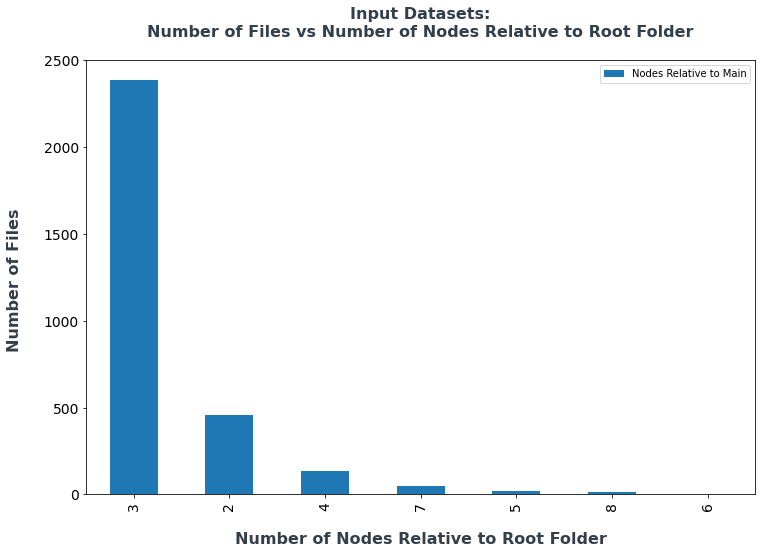

In [13]:
node_freq = pd.DataFrame(input_df['Nodes Relative to Main'].value_counts())
fig, ax = plt.subplots(figsize=(12,8))
node_freq.plot(ax=ax, kind='bar')

# Set label style.
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Input Datasets:\nNumber of Files vs Number of Nodes Relative to Root Folder\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nNumber of Nodes Relative to Root Folder', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('Number of Files \n', fontsize=16, fontweight='black', color = '#333F4B')

In [14]:
input_df[input_df['Nodes Relative to Main']==4]['Root Folder']

252           DATM
253           DATM
254           DATM
255           DATM
256           DATM
           ...    
2767    DATM_CDEPS
2768    DATM_CDEPS
2769    DATM_CDEPS
2770    DATM_CDEPS
2771    DATM_CDEPS
Name: Root Folder, Length: 133, dtype: object

In [15]:
deepest_nodes = list(set(input_df[input_df['Nodes Relative to Main']==8]['Root Folder']))
print('\033[1m'+ f"Root folder(s) with deepest level in folder structure (Total: {len(deepest_nodes)}):\033[0m\n", deepest_nodes)

majority_nodes = list(set(input_df[input_df['Nodes Relative to Main']==3]['Root Folder']))
print('\033[1m'+ f"\n\nRoot folders with majority of input files within 3 nodes relative to the main timestamped input folder (Total: {len(majority_nodes)}):\033[0m\n", majority_nodes)


Root folder(s) with deepest level in folder structure (Total: 1):
 ['GOCART']


Root folders with majority of input files within 3 nodes relative to the main timestamped input folder (Total: 25):
 ['FV3_input_data384', 'MOM6_FIX_DATM', 'FV3_input_data_gsd', 'GOCART', 'FV3_input_data_regional_esg', 'CICE_FIX', 'CICE_IC', 'FV3_input_data_L149', 'FV3_input_data', 'FV3_input_data_sar', 'FV3_input_data_conus13km', 'FV3_fix', 'FV3_hafs_input_data', 'FV3_input_frac', 'fv3_regional_control', 'MOM6_FIX', 'FV3_input_data_INCCN_aeroclim', 'DATM_CDEPS', 'FV3_input_data48', 'FV3_input_data768', 'FV3_input_data192', 'fv3_regional_c768', 'WW3_input_data_20211113', 'FV3_fix_tiled', 'CPL_FIX']


### Determine Storage Size Distribution (GB) per Timestamped Input Dataset 
Determining the file storage per timestamped input dataset will provide insights on the current dataset structure's storage size and inform the team on how much storage will be needed for the UFS input datasets for deployment.

Text(0, 0.5, 'Timestamped Input Dataset\n')

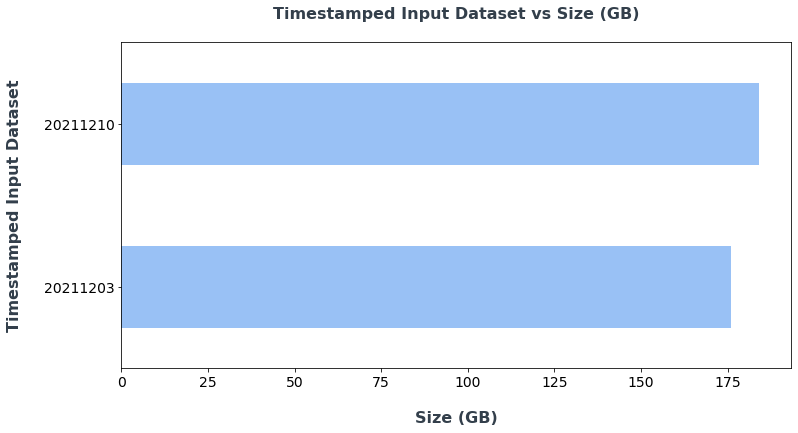

In [16]:
input_sizeperdate = pd.DataFrame(input_df.groupby(['Date'])['Size'].sum()/(1024**3))

# Variation in storage size per input dataset.
fig, ax = plt.subplots(figsize=(12,6))
input_sizeperdate.plot(kind='barh', legend = False, color= (0, 0.4, 0.9, 0.5), ax=ax, alpha=0.4, linewidth=2)

# Set label style.
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Timestamped Input Dataset vs Size (GB)\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nSize (GB)', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('Timestamped Input Dataset\n', fontsize=16, fontweight='black', color = '#333F4B')


### Determine Storage Size Distribution (GB) per UFS Component per Timestamped Input Dataset 
Determining the file storage per UFS component per timestamped input dataset will provide insights on the current dataset structure's storage size by UFS component and can assist in detecting any potential outliers/anomalies within a given UFS component input data structure. 

Text(0, 0.5, '(Timestamped Input Dataset, UFS Component)\n')

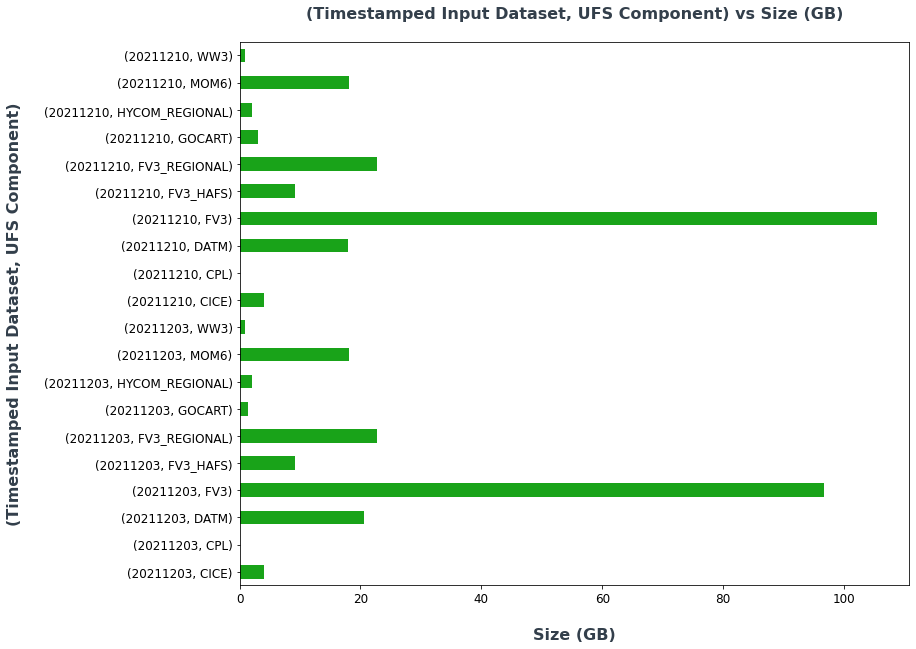

In [17]:
# Storage size conversion to GB per UFS component.
input_sizepercomp = pd.DataFrame(input_df.groupby(['Date', 'UFS Component'])['Size'].sum()/(1024**3))

# Distribution in storage size per input dataset per component.
fig, ax = plt.subplots(figsize=(12,10))
input_sizepercomp.plot(kind='barh', legend = False, color= (0, 0.6, 0, 0), ax=ax, alpha=0.9, linewidth=6)

# Set label style.
ax.tick_params(axis='both', labelsize=12)
ax.set_title('(Timestamped Input Dataset, UFS Component) vs Size (GB)\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nSize (GB)', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('(Timestamped Input Dataset, UFS Component)\n', fontsize=16, fontweight='black', color = '#333F4B')


### One root folder not UFS component labelled, but are input data (OISST) from the satellite office of NOAA (NESDIS)

In [18]:
# Folders not UFS component labelled, but are input data (OISST) from the satellite office of NOAA (NESDIS)
print('\033[1m'+ f"Folders labelled as UFS components presented in input datasets:\033[0m\n{set(input_df['UFS Component'])}")
input_df[input_df['UFS Component'].isnull()].head()

Folders labelled as UFS components presented in input datasets:
{nan, 'WW3', 'DATM', 'GOCART', 'FV3_HAFS', 'FV3_REGIONAL', 'MOM6', 'CICE', 'HYCOM_REGIONAL', 'CPL', 'FV3'}


,Date,Root Folder,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,UFS Component,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7
1499,20211203,DOCN_OISST_input_data,input-data-20211203/DOCN_OISST_input_data,TX025_210327_ESMFmesh_py.nc,58111139,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211203,DOCN_OISST_input_data,None,None,None,None,None,None
1500,20211203,DOCN_OISST_input_data,input-data-20211203/DOCN_OISST_input_data,oisst-avhrr-v02r01.merged_nozlev.nc,99585538,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211203,DOCN_OISST_input_data,None,None,None,None,None,None
1501,20211203,DOCN_OISST_input_data,input-data-20211203/DOCN_OISST_input_data,sst.day.mean.2019.nc,476611864,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211203,DOCN_OISST_input_data,None,None,None,None,None,None
1502,20211203,DOCN_OISST_input_data,input-data-20211203/DOCN_OISST_input_data,TX025_201215_ESMFmesh_direct.nc,78847135,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211203,DOCN_OISST_input_data,None,None,None,None,None,None
3062,20211210,DOCN_OISST_input_data,input-data-20211210/DOCN_OISST_input_data,TX025_210327_ESMFmesh_py.nc,58111139,NaN,NaN,NaN,nc,NaN,input,2,input-data-20211210,DOCN_OISST_input_data,None,None,None,None,None,None


## Analysis (as of 02/03/22): UFS Input Datasets

- After cleaning of the input datasets, the new input dataset storage size reserved on Orion has decreased from 500GB to 350GB and the file size distribution between the timestamped datasets are similar to each other with a negligible difference in storage size overall since, last BDP meeting (on 01/31/22).

- After cleaning of the input datasets, there are duplicated data files within the same directory path of a given timestamped input dataset. If files of similar name and size occur more than once within a root folder, then the files are seperated by subfolders at deeper node levels as they are dependent on resolutions.

- There are 2 timestamped input datasets and 208 unique directory paths leading to baseline data files.
- There are 33 unique root folders across all input datasets. Majority of these root folders are UFS component labelled with one root folder labelled as __DOCN_OISST_input_data__ ("input data (OISST) from the satellite office of NOAA (NESDIS)").

- Root folder with the largest number of nodes ("deepest level") with 8 nodes relative to main timestamped input folder in depth:
    - GOCART
    
- Root folders featuring the next largest number of nodes with 4 nodes relative to main timestamped input folder in depth:
    - DATM
    - DATM_CDEPS
    - FV3_input_data_INCCN_aeroclim
    - MOM6_IC
    
- Majority of the files are located within 3 nodes relative to the main timestamped input folder. There are 25 root folders with at least 3 nodes relative to the main timestamped input folder in depth.
    - CICE_IC
    - WW3_input_data_20211113
    - fv3_regional_c768
    - FV3_input_data384
    - FV3_input_data_regional_esg
    - FV3_fix_tiled
    - FV3_input_data192
    - FV3_input_data_sar
    - MOM6_FIX_DATM
    - FV3_hafs_input_data
    - FV3_input_data_conus13km
    - FV3_input_data768
    - CICE_FIX
    - CPL_FIX
    - FV3_input_frac
    - fv3_regional_control
    - FV3_fix
    - FV3_input_data_L149
    - MOM6_FIX
    - FV3_input_data_gsd
    - FV3_input_data48

- All root folders are UFS component labelled. There is only one root folder, __DOCN_OISST_input_data__, which is not a UFS component and contains  input data (OISST) gathered from the satellite office of NOAA (NESDIS).

### Findings (as of 02/03/22):

- __$\color{blue}{\text{[Sent Findings to Jun on 02/03/22 via Email]}}$__ Although its file is relatively small, would it be reasonable to not have them in different subfolders, but rather one subfolder within their respective root directory -- since __grid_spec.nc__ is not specific to the number of vertical levels? For example, placing __grid_spec.nc__ into a single location (in this case, for the input-data-20211210's FV3_input_data384 resolution, the input-data-20211210/FV3_input_data384/INPUT folder) -- rather than in two or three different subfolders per unique root path as shown below:

    - input-data-20211210/FV3_input_data384/INPUT/__grid_spec.nc__ (~22k)
    - input-data-20211210/FV3_input_data384/INPUT_L127/__grid_spec.nc__ (~22k)
    - input-data-20211210/FV3_input_data384/INPUT_L127_GDAS/__grid_spec.nc__ (~22k)

    - input-data-20211210/FV3_input_data/INPUT_L127/__grid_spec.nc__ (~22k)
    - input-data-20211210/FV3_input_data/INPUT/__grid_spec.nc__ (~22k)

    - input-data-20211210/FV3_input_data192/INPUT_L127/__grid_spec.nc__ (~22k)
    - input-data-20211210/FV3_input_data192/INPUT/__grid_spec.nc__ (~22k)
    
> __Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/03/22 via Email]}}$__
"yes, those  __grid_spec.nc__ are the same for the same resolution.  Currently we put all the INPUT data  in one of these INPUT directories. We can move them one level up, but that requires script change as you pointed out, also developers may be confused that the INPUT data are not stay in the same place. So we can change it, but need some time to convey the information to the developers. 

> __$\color{darkgreen}{\text{[Response from Jun on 02/07/22 via Email]}}$__
I discussed the [Finding 1 on input data] with my team who developed the RT. Several comments are: these __grid_spec.nc__ files are small, moving them outside the INPUT directory where they belong will make the RT script complicated. We need to let all developers be aware of this change before making the change." 

> __$\color{magenta}{\text{[Conclude]}}$__
If deemed necessary when restructuring UFS datasets, we can allocate these __grid_spec.nc__ file as one __grid_spec.nc__ file to one directory since, there is no reason for them to be categorized into resolutions as they are not dependent on resolution. The tradeoff is between a small amount of duplicate files vs the time developers have to perform to make the changes within the the RT script which may not be worthwhile considering the tradeoff for this change." 


- __$\color{blue}{\text{[Sent Findings to Jun on 02/03/22 via Email]}}$__ Timestamped __20211203__ & __20211210__ __input datasets__ differ such that:

    - __20211210 input dataset__ contains folder, __/FV3_input_data_conus13km__, whereas __20211203 input dataset__ does not contain folder, __/FV3_input_data_conus13km__.
    - __20211203 input dataset__ contains folder, __/DATM__, whereas __20211210 input dataset__ does not contain folder, __/DATM__.

> __Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/03/22 via Email]}}$__
"the changes are from recent PRs. A new test was added, the input data is FV3_input_data_conus13km. Also some old DATM tests were removed." 

- __$\color{blue}{\text{[Sent Findings to Jun on 02/03/22 via Email]}}$__ The deepest data folder structure is the GOCART with a maximum level of 8 nodes (subfolders) relative to its main directory in depth. The majority of the data files within the input dataset structure hovers around 3 nodes relative to its main directory in depth.

>__Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/03/22 via Email]}}$__
"this may need some work to reduce the depth, I need to talk to the developers."

> __Follow-up (02/14/22)__

> __$\color{blue}{\text{[Response to Jun on 02/14/22 via Email]}}$__ Noted. Also, the data analytics pythonic tool that I have created to observe the current structure & details of the UFS datasets is capable of providing your team an overview of what is currently residing within GOCART's dataset.

> __$\color{magenta}{\text{[Conclude]}}$__ If needed, the tool could transport these GOCART dataset details in a categorical fashion for your team to a .csv spreadsheet or formatted table if desired (as oppose to your team logging in & recording what data files are currently residing for GOCART as well as any other UFS component data files of interest). __**For a reference on the findings for GOCART as of last sprint, documentation is within the following link:__ https://drive.google.com/drive/folders/12egYWleyqaWu9BDIDsPSG9j_fIQ8Ob1b


### Findings (as of 02/01/22):
- __$\color{green}{\text{[RESOLVED]}}$__ There is only one folder ( __/FV3_hafs_input_data__) in Timestamped __20210930 input dataset__. 
    - __[Follow-up w/ NOAA on 02/03/22]__ Removal of Timestamped __20210930 input dataset__ on Orion by NOAA resolved issue. 
 

### Findings (as of 01/31/22):


- __$\color{green}{\text{[RESOLVED]}}$__ Inconsistency in nomenclature of the input files containing grid information and the initial conditions listed and described in Table 4.2 -- they are described as having the following format: __sfc_data.tile[1-6,7].nc__, __gfs_data.tile[1-6,7].nc__, __gfs_bndy.tile[1-6,7].nc__, __oro_data.tile[1-6,7].nc__, 
__gfs_ctrl.nc__, __sfc_ctrl.nc__, __C[RES]_grid.tile[1-6,7].nc__.
    - __Example:__ __oro_data_ss.tile1.nc__	
    - __[Follow-up w/ NOAA (Jun W.) on 02/01/22]__ Agreed that the filenames will not change, but the folder names can be subject to change if needed during data restructuring.


- __$\color{green}{\text{[RESOLVED]}}$__ According to the UFS guide (https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html), "No fix files are required for CICE6," however there is a __/CICE_FIX__ folder. Why is there a CICE_FIX folder ? Is this a folder containing grid information data files which NOAA considers as literally a fix file? 
    - __[Follow-up w/ NOAA (Jun W. & Denise W.) on 02/01/22]:__ Discussion w/ NOAA, confirmed the files in "CICE_FIX" folder does not follow the UFS Guide's definition of static "fix" data file. Thus, its foldername could be subject to change -- in an effort to maintain data structure consistency & comply with the UFS Guide's definition of static ("fix") files. Agreed that when data is being restructured that it complies with the UFS guide: https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html]__


- __$\color{green}{\text{[RESOLVED]}}$__ Some of static input files will either reside outside or within the '/INPUT' folder. Sol: Will need to re-structure this for consistency. 
    - __Example:__ __co2historicaldata_YYYY.txt__ & __aerosol.dat__ will either be outside or within the '/INPUT' folder.
    - __[Follow-up w/ NOAA on 02/01/22]__ Cleaning & removal of timestamped input dataset files on Orion by NOAA resolved issue. 
    

- __$\color{darkorange}{\text{[DETAILS PENDING]}}$__ Per https://ufs-weather-model.readthedocs.io/en/latest/InputsOutputs.html, "GOCART information in progress". Need to determine which GOCART related data files are inputs. Need to acquire the GOCART I/O list of files for confirmation on 
for its categorization.    
    - __[Follow-up w/ NOAA (Jun W.) on 02/01/22]:__ Agreed that GOCART data will not be analyze or restructured until information regarding its data is provided by NOAA and/or UFS guide.
        
    
### Notes
- The following files are specific to the number of either the vertical and/or horizontal resolution levels 
    - __gfs_ctrl.nc__  Defines vertical coordinate so, dependent on the vertical resolution, but not horizontal resolution. 
    - __gfs_data.nc__ (IC) dependent on the vertical resolution. 3-dimensional ICs (lat,lon,vertical height).
    - __sfc_data.nc__ (IC) dependent on the vertical resolution.
    - __oro_data.nc__ dependent on the vertical resolution.


# Information on Baseline Datasets 

In [37]:
baseline_df[(baseline_df['Date'] == '20220224') & (baseline_df['input_or_restart'] != 'restart')]['Filename'].unique()

array(['sfcf006.nc', 'out_pnt.ww3', 'out_grd.ww3', 'atmf006.nc',
       'sfcf036.tile6.nc', 'atmf036.tile2.nc', 'atmf036.tile4.nc',
       'sfcf036.tile1.nc', 'sfcf036.tile3.nc', 'atmf036.tile3.nc',
       'sfcf036.tile5.nc', 'sfcf036.tile4.nc', 'sfcf036.tile2.nc',
       'atmf036.tile6.nc', 'atmf036.tile5.nc', 'atmf036.tile1.nc',
       'sfcf001.nc', 'atmf000.nc', 'sfcf000.nc', 'atmf001.nc',
       'dynf001.nc', 'phyf001.nc', 'phyf000.nc', 'dynf000.nc',
       'phyf024.nc', 'dynf024.nc', 'HURPRS.GrbF24', 'HURPRS.GrbF00',
       'archv.2019_241_06.a', 'archs.2019_241_06.a', 'GFSFLX.GrbF00',
       'GFSPRS.GrbF00', 'atmf024.nc', 'GFSFLX.GrbF24', 'sfcf024.nc',
       'GFSPRS.GrbF24', 'atmf000.tile6.nc', 'atmf001.tile4.nc',
       'atmf000.tile5.nc', 'atmf001.tile1.nc', 'sfcf000.tile2.nc',
       'sfcf000.tile5.nc', 'atmf001.tile2.nc', 'sfcf001.tile3.nc',
       'atmf000.tile1.nc', 'atmf001.tile3.nc', 'sfcf000.tile1.nc',
       'sfcf000.tile6.nc', 'sfcf001.tile1.nc', 'sfcf000.tile3.nc',
 

In [19]:
baseline_df.head()

,Date,CNTL Folder,Compiler,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3
0,20220222,hafs_regional_atm_wav,INTEL,develop-20220222/INTEL/hafs_regional_atm_wav,sfcf006.nc,162093776,NaN,NaN,NaN,nc,NaN,3,develop-20220222,INTEL,hafs_regional_atm_wav,None
1,20220222,hafs_regional_atm_wav,INTEL,develop-20220222/INTEL/hafs_regional_atm_wav,out_pnt.ww3,12223621,NaN,NaN,NaN,ww3 binary,NaN,3,develop-20220222,INTEL,hafs_regional_atm_wav,None
2,20220222,hafs_regional_atm_wav,INTEL,develop-20220222/INTEL/hafs_regional_atm_wav,out_grd.ww3,197073682,NaN,NaN,NaN,ww3 binary,NaN,3,develop-20220222,INTEL,hafs_regional_atm_wav,None
3,20220222,hafs_regional_atm_wav,INTEL,develop-20220222/INTEL/hafs_regional_atm_wav,atmf006.nc,1657307858,NaN,NaN,NaN,nc,NaN,3,develop-20220222,INTEL,hafs_regional_atm_wav,None
4,20220222,cpld_control_c192_p8,INTEL,develop-20220222/INTEL/cpld_control_c192_p8,sfcf036.tile6.nc,23192640,192.0,50.0,NaN,nc,NaN,3,develop-20220222,INTEL,cpld_control_c192_p8,None


In [20]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32718 entries, 0 to 32717
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    32718 non-null  object 
 1   CNTL Folder             32718 non-null  object 
 2   Compiler                32718 non-null  object 
 3   Relative Directory      32718 non-null  object 
 4   Filename                32718 non-null  object 
 5   Size                    32718 non-null  int64  
 6   Res (C)                 7366 non-null   float64
 7   Res (km)                7366 non-null   float64
 8   Couple Res              0 non-null      float64
 9   DataType                32321 non-null  object 
 10  input_or_restart        17237 non-null  object 
 11  Nodes Relative to Main  32718 non-null  int64  
 12  Node0                   32718 non-null  object 
 13  Node1                   32718 non-null  object 
 14  Node2                   32718 non-null

In [21]:
# Unique Directories & Total Directories leading to Data Files for Input Datasets.
tot_baseline_filedirs = len(set(baseline_df['Relative Directory']))
print('\033[1m'+ f"\nTotal Unique Directories leading to Baseline Data Files:\033[0m\n{tot_baseline_filedirs}")
#print(f"\nUnique Directories leading to Baseline Data File:\033[0m\n{set(baseline_df['Relative Directory'])}")

# Total Timestamped Baseline Datasets.
tot_baseline_ts = len(set(baseline_df['Date']))
print('\033[1m'+ f"\nTotal Timestamps for Baseline Datasets:\033[0m\n{tot_baseline_ts}")

# Total Storage Size per Timestamped Baseline Dataset (GB).
size_per_baseline_gb = baseline_df.groupby(['Date'])['Size'].sum()/(1024**3)
print('\033[1m'+ f"\nStorage Size per Timestamped Baseline Dataset (GB):\033[0m\n{size_per_baseline_gb}")

# Overall Storage Size of All Timestamped Baseline Datasets (GB, TB).
overall_baseline_size_gb = round(baseline_df['Size'].sum()/(1024**3), 1)
overall_baseline_size_tb = round(baseline_df['Size'].sum()/(1024**4), 2)
print('\033[1m'+ f"\nOverall Storage Size of All Timestamped Baseline Datasets (GB):\033[0m\n{overall_baseline_size_gb}")
print('\033[1m'+ f"\nOverall Storage Size of All Timestamped Baseline Datasets (TB):\033[0m\n{overall_baseline_size_tb}")

# Unique Baseline CNTL Folders.
unique_baseline_root_folders = set(baseline_df['CNTL Folder'])
print('\033[1m'+ f"\nUnique CNTL Folders Across All Baseline Datasets:\033[0m\n{unique_baseline_root_folders}")

# Total Unique Baseline CNTL Folders.
num_unique_baseline_root = len(set(baseline_df['CNTL Folder']))
print('\033[1m'+ f"\nTotal Unique CNTL Folders Across All Baseline Datasets:\033[0m\n{num_unique_baseline_root}")



Total Unique Directories leading to Baseline Data Files:
2686

Total Timestamps for Baseline Datasets:
26

Storage Size per Timestamped Baseline Dataset (GB):
Date
20210208     83.971356
20210212     96.780035
20211203    336.834757
20211206    341.830243
20211209    341.829013
20211210    359.157363
20211213    359.157303
20211214    359.157356
20211220    359.158158
20211221    359.157921
20211222    361.213379
20211229    328.550624
20211230    328.557469
20220103    328.557354
20220106    328.571890
20220107    331.575076
20220112    369.433619
20220113    369.434606
20220128    373.076101
20220207    373.074992
20220210    374.746005
20220214    376.566096
20220215    374.746578
20220217    382.895274
20220222    382.895274
20220224    382.895056
Name: Size, dtype: float64

Overall Storage Size of All Timestamped Baseline Datasets (GB):
8763.8

Overall Storage Size of All Timestamped Baseline Datasets (TB):
8.56

Unique CNTL Folders Across All Baseline Datasets:
{'control_stochy_

### Generate CSV for Latest Baseline Data Files.

In [22]:
# Input Dataset's Timestamp of Interest
ts_of_interest = '20220224'
dataset_type = 'Baseline'

# Extract Unique Data Files in Input Dataset's Timestamp of Interest.
latest_unique_bl_files = [baseline_df[baseline_df['Date']== ts_of_interest]['Filename'].unique()]
latest_unique_bl_df = pd.DataFrame(latest_unique_bl_files, index = [f'Latest Unique {dataset_type} Data Files (as of {ts_of_interest})']).T 

# Extract All Data Files in Input Dataset's Timestamp of Interest.
latest_bl_df = baseline_df[baseline_df['Date']== ts_of_interest]

# Save Info on Input Dataset's Timestamp of Interest to CSV.
with pd.ExcelWriter(f"Latest_{dataset_type}_Data_Files{ts_of_interest}.xlsx") as writer:
   
    # Partition Info on Input Dataset's into Specified CSV sheets.
    latest_bl_df.to_excel(writer, sheet_name=f"Latest {dataset_type} Data", index=False)
    latest_unique_bl_df.to_excel(writer, sheet_name=f"Latest Unique {dataset_type} Data", index=False)
    


### CNTL Folders per Timestamp Baseline Dataset

The number of CNTL folders will provide insight on the baseline dataset structure's root nodes. Acquiring information on the root nodes per dataset will assist in the reconstruction & mapping of the data files.

In [23]:
root_per_bl_ts.head() 

,20220210,20220217,20220224,20211220,20220107,20220222,20211209,20220113,20210208,20211203,...,20220103,20211229,20211210,20211214,20220215,20220214,20211213,20210212,20220112,20211221
0,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,fv3_rrfs_v1alpha_ccpp,control_stochy_debug,...,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,control_stochy_debug,fv3_rrfs_v1alpha_ccpp,control_stochy_debug,control_stochy_debug
1,fv3_regional_hafs,fv3_regional_hafs,fv3_regional_hafs,HAFS_v0_HWRF_thompson_debug,fv3_regional_hafs,fv3_regional_hafs,HAFS_v0_HWRF_thompson_debug,fv3_regional_hafs,FV3_input_data_gsd,HAFS_v0_HWRF_thompson_debug,...,fv3_regional_hafs,fv3_regional_hafs,HAFS_v0_HWRF_thompson_debug,HAFS_v0_HWRF_thompson_debug,fv3_regional_hafs,fv3_regional_hafs,HAFS_v0_HWRF_thompson_debug,FV3_input_data_gsd,fv3_regional_hafs,HAFS_v0_HWRF_thompson_debug
2,control_wam_debug,control_wam_debug,control_wam_debug,fv3_regional_hafs,control_wam_debug,control_wam_debug,fv3_regional_hafs,control_wam_debug,fv3_regional_v15p2_repro,fv3_regional_hafs,...,control_wam_debug,control_wam_debug,fv3_regional_hafs,fv3_regional_hafs,control_wam_debug,control_wam_debug,fv3_regional_hafs,fv3_regional_v15p2_repro,control_wam_debug,fv3_regional_hafs
3,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,fv3_rap,hafs_regional_atm,fv3_regional_v15p2_debug_ccpp,fv3_rap,...,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,hafs_regional_atm,fv3_regional_v15p2_debug_ccpp,hafs_regional_atm,hafs_regional_atm
4,rap_control,rap_control,rap_control,rap_control,rap_control,rap_control,hafs_regional_atm,rap_control,FV3_input_data,hafs_regional_atm,...,rap_control,rap_control,rap_control,rap_control,rap_control,rap_control,rap_control,FV3_input_data,rap_control,rap_control


In [24]:
print('\033[1m'+ f"Root Folders per Timestamped Baseline Dataset:\033[0m\n")
root_per_bl_ts.info()

Root Folders per Timestamped Baseline Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   20220210  93 non-null     object
 1   20220217  94 non-null     object
 2   20220224  94 non-null     object
 3   20211220  87 non-null     object
 4   20220107  87 non-null     object
 5   20220222  94 non-null     object
 6   20211209  82 non-null     object
 7   20220113  88 non-null     object
 8   20210208  13 non-null     object
 9   20211203  80 non-null     object
 10  20220207  93 non-null     object
 11  20211230  85 non-null     object
 12  20211206  82 non-null     object
 13  20220106  85 non-null     object
 14  20211222  88 non-null     object
 15  20220128  93 non-null     object
 16  20220103  85 non-null     object
 17  20211229  85 non-null     object
 18  20211210  87 non-null     object
 19  20211214  87 non-null     object
 20  20220215

In [25]:
# Determine similar CNTL folders between timestamps.
input_ts1 = '20220112'
input_ts2 = '20220107' 
list1 = [x for x in root_per_bl_ts[input_ts1] if x != None]
list2 = [x for x in root_per_bl_ts[input_ts2] if x != None]
inlist1_notlist2 = sorted(list(set(list1) - set(list2)))
inlist2_notlist1 = sorted(list(set(list2) - set(list1)))
print('\033[1m'+ f"Folder not in {input_ts1}, but in {input_ts2}:\033[0m\n{inlist2_notlist1}")
print('\033[1m'+ f"\nFolder not in {input_ts2}, but in {input_ts1}:\033[0m\n{inlist1_notlist2}")

Folder not in 20220112, but in 20220107:
['control_debug_p7', 'control_p7', 'cpld_control_c192_p7', 'cpld_control_c384_p7', 'cpld_control_c96_p7', 'cpld_control_p7', 'cpld_debug_p7']

Folder not in 20220107, but in 20220112:
['control_debug_p8', 'control_p8', 'cpld_bmark_p8', 'cpld_control_c192_p8', 'cpld_control_c384_p8', 'cpld_control_c96_p8', 'cpld_control_p8', 'cpld_debug_p8']


### Determine Duplicated Files in Baseline Datasets

A filtering of a list of files occuring more than once of the same file size per cntl folder and transfering it to a csv file for analysis will provide insights on the what baseline files are being duplicated.

#### Filter to Mutilple Files Dataframe & Save to CSV File

In [26]:
ts_of_interest_bl = None # [Options]: None, set to baseline dataset timestamp of interest (e.g.'20210208', '20210212')
multiple_files_in_cntl_df = data_reader.get_freq_files(baseline_df, ts_of_interest_bl, 'baseline')
multiple_files_in_cntl_df.head()

,Date,CNTL Folder,Compiler,Relative Directory,Filename,Size,Res (C),Res (km),Couple Res,DataType,input_or_restart,Nodes Relative to Main,Node0,Node1,Node2,Node3
3771,20210212,FV3_input_data,INTEL,ufs-public-release-v2-20210212/INTEL/FV3_input...,C96_grid.tile1.nc,2094935,NaN,NaN,NaN,nc,restart,4,ufs-public-release-v2-20210212,INTEL,FV3_input_data,RESTART
3889,20210212,FV3_input_data,INTEL,ufs-public-release-v2-20210212/INTEL/FV3_input...,C96_grid.tile1.nc,2094935,NaN,NaN,NaN,nc,NaN,4,ufs-public-release-v2-20210212,INTEL,FV3_input_data,INPUT
10362,20210208,FV3_input_data,INTEL,ufs-public-release-v2-20210208/INTEL/FV3_input...,C96_grid.tile1.nc,2094935,NaN,NaN,NaN,nc,restart,4,ufs-public-release-v2-20210208,INTEL,FV3_input_data,RESTART
10480,20210208,FV3_input_data,INTEL,ufs-public-release-v2-20210208/INTEL/FV3_input...,C96_grid.tile1.nc,2094935,NaN,NaN,NaN,nc,NaN,4,ufs-public-release-v2-20210208,INTEL,FV3_input_data,INPUT
3784,20210212,FV3_input_data,INTEL,ufs-public-release-v2-20210212/INTEL/FV3_input...,C96_grid.tile2.nc,2094935,NaN,NaN,NaN,nc,restart,4,ufs-public-release-v2-20210212,INTEL,FV3_input_data,RESTART


### Determine Current Baseline Data Structure's Depth Levels

The number of nodes ("folders") relative to each root folder will provide insights on the current dataset structure's depth. Acquiring information on the bandwidth of the nodes per file relative to their root folder will assist in the reconstruction & mapping of the data files.

Text(0, 0.5, 'Number of Files \n')

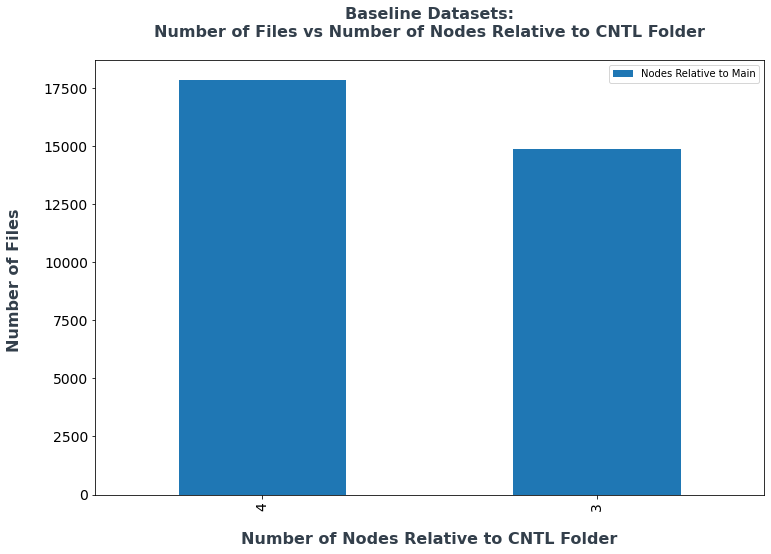

In [27]:
node_freq_bl = pd.DataFrame(baseline_df['Nodes Relative to Main'].value_counts())
fig, ax = plt.subplots(figsize=(12,8))
node_freq_bl.plot(ax=ax, kind='bar')

# Set label style.
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Baseline Datasets:\nNumber of Files vs Number of Nodes Relative to CNTL Folder\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nNumber of Nodes Relative to CNTL Folder', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('Number of Files \n', fontsize=16, fontweight='black', color = '#333F4B')

In [28]:
deepest_nodes_bl = list(set(baseline_df[baseline_df['Nodes Relative to Main']==4]['CNTL Folder']))
print('\033[1m'+ f"CNTL folder(s) with deepest level in folder structure (Total: {len(deepest_nodes_bl)}):\033[0m\n", deepest_nodes_bl)


CNTL folder(s) with deepest level in folder structure (Total: 59):
 ['cpld_debug_p7', 'cpld_bmark_p7', 'FV3_input_data_gsd', 'HAFS_v0_HWRF_thompson_debug', 'fv3_regional_control_ccpp', 'fv3_rap', 'fv3_gfs_v15p2_ccpp', 'cpld_control_c192_p7', 'FV3_input_data_regional', 'datm_cdeps_control_cfsr', 'rap_control', 'fv3_rrfs_v1alpha_debug_ccpp', 'fv3_rrfs_v1alpha_debug', 'fv3_rrfs_v1beta_debug', 'rap_sfcdiff', 'FV3_input_data', 'fv3_gfs_v15p2_debug_ccpp', 'datm_cdeps_bulk_cfsr', 'control_c48', 'fv3_regional_noquilt', 'fv3_hrrr', 'fv3_gsd_debug', 'cpld_bmark_p8', 'control_c384gdas_wav', 'control_p7_rrtmgp', 'cpld_control_c96_p7', 'cpld_control_p7', 'datm_cdeps_mx025_gefs', 'cpld_control_c384_p7', 'fv3_regional_v15p2_ccpp', 'control', 'fv3_rrfs_v1alpha_ccpp', 'cpld_debug_p8', 'HAFS_v0_HWRF_thompson', 'control_p8', 'datm_cdeps_debug_cfsr', 'fv3_regional_v15p2_debug_ccpp', 'rrfs_v1beta', 'cpld_control_c192_p8', 'fv3_gsd', 'ESG_HAFS_v0_HWRF_thompson_debug', 'datm_cdeps_stochy_gefs', 'fv3_rrfs_v1a

### Determine Storage Size Distribution (GB) per Timestamped Baseline Dataset 
Determining the file storage per timestamped baseline dataset will provide insights on the current dataset structure's storage size and inform the team on how much storage will be needed for the UFS baseline datasets for deployment.

Text(0, 0.5, 'Timestamped Baseline Dataset\n')

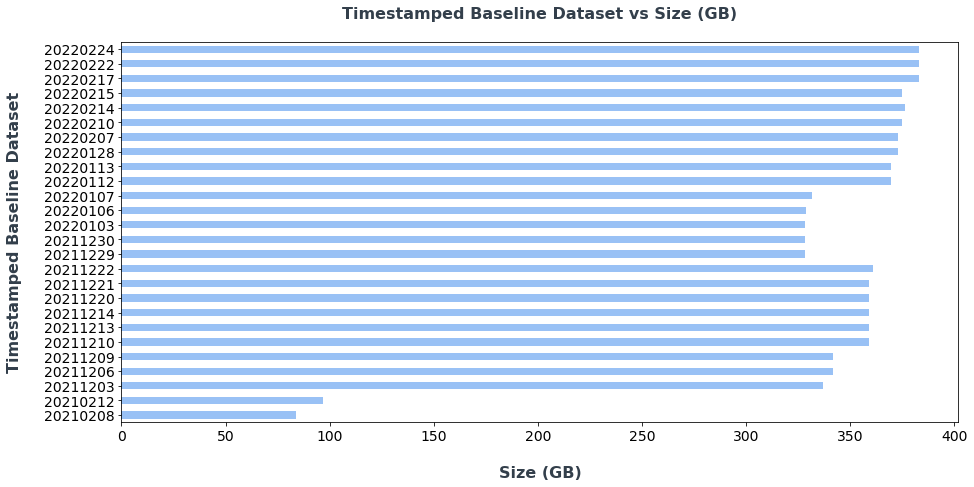

In [29]:
baseline_sizeperdate = pd.DataFrame(baseline_df.groupby(['Date'])['Size'].sum()/(1024**3))

# Variation in storage size per baseline dataset.
fig, ax = plt.subplots(figsize=(15,7))
baseline_sizeperdate.plot(kind='barh', legend = False, color= (0, 0.4, 0.9, 0.5), ax=ax, alpha=0.4, linewidth=10)

# Set label style.
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Timestamped Baseline Dataset vs Size (GB)\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nSize (GB)', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('Timestamped Baseline Dataset\n', fontsize=16, fontweight='black', color = '#333F4B')


### Determine Storage Size Distribution (GB) per CNTL Folder Called by Regression "/tests" Files.
Determining the file storage per CNTL foldername called by Regression Test Framework's "/tests" Files will provide insights on a given baseline dataset's storage size required for a given regression test.

### Storage Size Distribution (GB) per CNTL Folder Called by Regression "/tests" Files of Latest Baseline Dataset ('20220113'): 

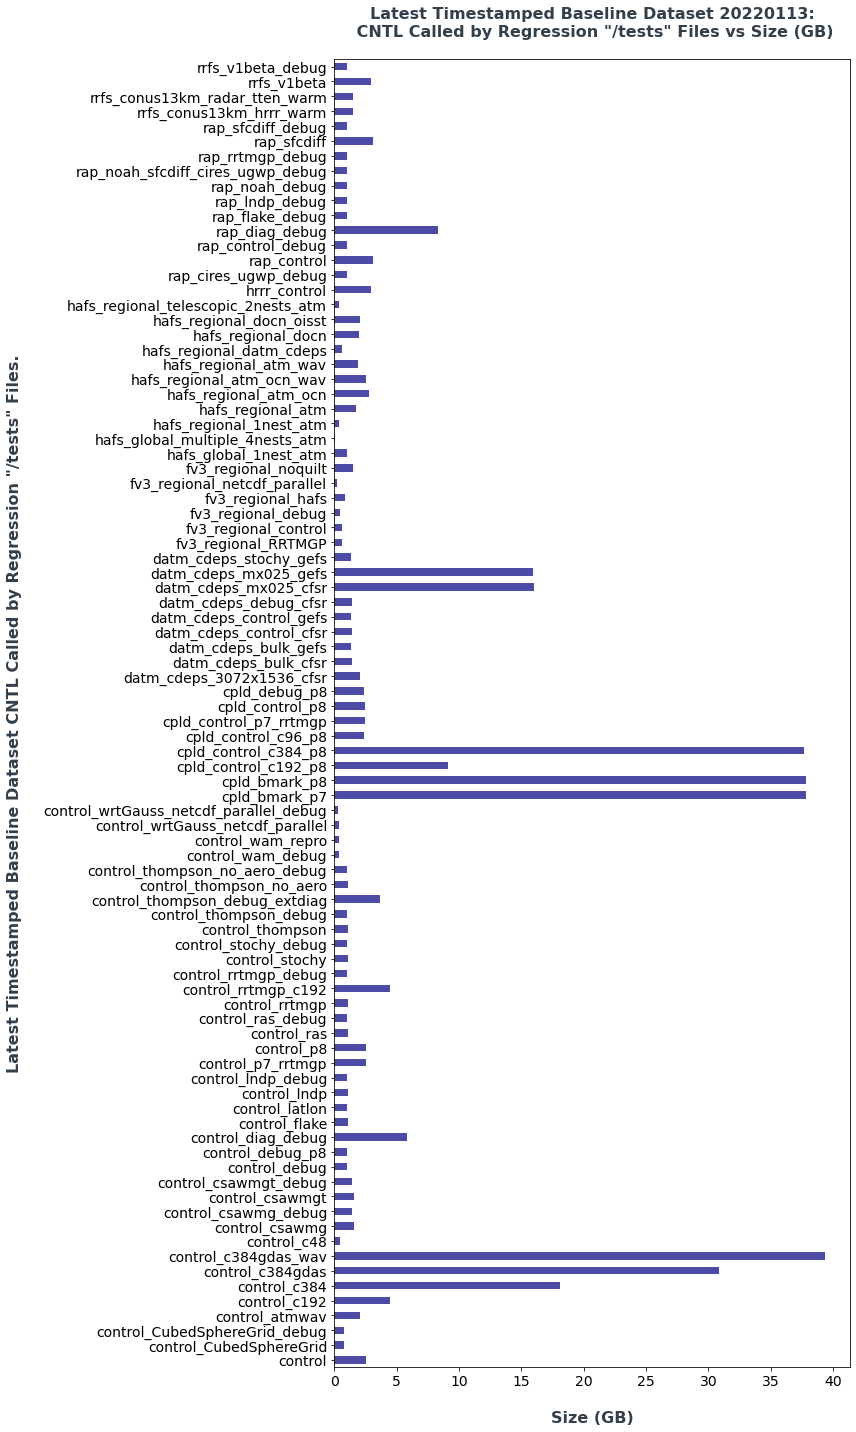

In [30]:
# Storage size conversion to GB per CNTL folder.
baseline_sizepercomp = pd.DataFrame(baseline_df.groupby(['Date', 'CNTL Folder'])['Size'].sum()/(1024**3))

# Latest baseline size per CNTL folder.
repo_date = '20220113'
latest_baseline_sizepercntl = baseline_sizepercomp.xs(repo_date, drop_level=True)

# Distribution in storage size per CNTL folder.
fig, ax = plt.subplots(figsize=(12,20))
latest_baseline_sizepercntl.plot(kind='barh', legend = False, color= (0, 0, 0.5, 0), ax=ax, alpha=0.7, linewidth=6)

# Set label style.
ax.tick_params(axis='both', labelsize=14)
ax.set_title(f'Latest Timestamped Baseline Dataset {repo_date}:\n CNTL Called by Regression "/tests" Files vs Size (GB)\n', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_xlabel('\nSize (GB)', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel(f'Latest Timestamped Baseline Dataset CNTL Called by Regression "/tests" Files.\n', fontsize=16, fontweight='black', color = '#333F4B')
plt.tight_layout()


## Analysis (as of 02/03/22): UFS Baseline Datasets

- Currently, the dataset storage size reserved on Orion is approximately 6 TB. the file size distribution between the timestamped datasets deviate from each other, in which most of the baseline datasets are approx. 350 GB, but 20210208 and 20210212 basleine datasets are only approx. 100 GB.

- There are 19 timestamped baseline datasets and 1891 unique directory paths leading to baseline data files.

- There are 126 unique CNTL folders across all baseline datasets. These CNTL folders are called by the UFS weather model repository's Regression Test framework in files reserved in "tests/tests" folder (https://github.com/ufs-community/ufs-weather-model/tree/develop/tests/tests).

- A given baseline datasets' largest number of nodes ("deepest level") is 4 nodes.
    
- The majority of the baseline data files are located within 4 nodes relative to the main timestamped baseline folder. 

- There are 59 CNTL folders with at least 4 nodes relative to the main timestamped baseline folder in depth.


### Findings (as of 02/03/22): 

- __$\color{blue}{\text{[Sent Findings to Jun via Email on 02/03/22]}}$__ As of 02/03/22, there are no duplicated baseline data files within the same directory path of a given timestamped baseline dataset. However, there are a few data files that have the same name and size which are occurring more than once within a baseline’s CNTL folder, and they are those files that are separated between the __/INPUT__ and __/RESTART__ subfolders for only two timestamped baseline datasets (20210208 and 20210212). Some of these files are:

    - aerosol.dat
    - co2historicaldata_YYYY
    - co2monthlycyc.txt 
    - solarconstant_noaa_an.txt
    - sfc_emissivity_idx.txt
    - C96_grid.tile#.nc
    - oro_data.tile#.nc
    - global_o3prdlos.f77
    - grid_spec.nc

Although the overall storage sizes of these files is minimal, that space that could be saved would be 24MB per the aforementioned timestamps if their duplicate file was removed and place in a single subfolder rather than two subfolders of a given CNTL folder.

> __Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/03/22 via Email]}}$__
"baseline, the __ufs-public-release-v2-20210208__ and __ufs-public-release-v2-20210212__ were generated before we reorganized the baseline data and the input data. As you see, the input data and the regression test baselines stayed in the same directory, and the input data were not cleaned up. And the corresponding model code version is almost one year old, I won't suggest looking at them." 


> __Follow-ups (02/14/22)__

> __$\color{blue}{\text{[Sent to Jun on 02/23/22 via Email]}}$__ •	From your previous email, you mentioned: 'baseline, the ufs-public-release-v2-20210208 and ufs-public-release-v2-20210212 were generated before we reorganized the baseline data and the input data. As you see, the input data and the regression test baselines stayed in the same directory, and the input data were not cleaned up. And the corresponding model code version is almost one year old, I won't suggest looking at them.' Based on your previous email and my findings: If ufs-public-release-v2-20210212 is to be ignored, then should only the following baseline datasets be ignored as well ?"
- ufs-v2.0.0: ufs-public-release-v2-20210212
- ufs-v1.1.0: ufs-public-release-v2-20200728
- ufs-v1.0.0: ufs-public-release-v2-20200224

> __Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/23/22 via Email]}}$__
"1) Yes. I'd suggest focusing on the new release"

> __$\color{magenta}{\text{[Conclude]}}$__
Consider focusing on all UFS repository code release versions ( "new release" versions) on GitHub, which does not include: 
- ufs-v2.0.0: ufs-public-release-v2-20210212
- ufs-v1.1.0: ufs-public-release-v2-20200728
- ufs-v1.0.0: ufs-public-release-v2-20200224

> __$\color{blue}{\text{[Sent to Jun on 02/23/22 via Email]}}$__ •	As I create a tool for which scrapes the current Github release version names to their respective baseline and input dataset timestamps, I noticed that __ufs-public-release-v2-20210212__ is being utilized for __'ufs-v2.0.0'__ release version of the UFS weather model repository. Does that mean that we should not take into account the dataset needed for  __'ufs-v2.0.0'__ release version of the UFS weather model repository and even perhaps those release versions older than  __'ufs-v2.0.0'__ ?
    > - In other words, what release versions of the UFS weather model repository should our team only be focused on for this year?
 
![input2codeversion](img/ufs_input2release_version.png)
![baseline2codeversion](img/ufs_baseline2release_version.png)   


> __Answer__

> __$\color{darkgreen}{\text{[Response from Jun on 02/23/22 via Email]}}$__
"2) I am not sure how this will be done this year. But for the previous releases, there was a release team formed, they decided the scope of the release, when all the required changes were available in the develop branch, we created a release branch out of the develop branch. So far I am not aware of the scope of the release yet."

- __$\color{blue}{\text{[Sent Findings to Jun via Email on 02/03/22]}}$__ Some of the timestamped baseline datasets differ in the number of CNTL folders that they posses. Should this be expected?

    - Folder not in 20220112, but in 20220107: 'control_debug_p7', 'control_p7', 'cpld_control_c192_p7', 'cpld_control_c384_p7', 'cpld_control_c96_p7', 'cpld_control_p7', 'cpld_debug_p7'

    - Folder not in 20220107, but in 20220112: 'control_debug_p8', 'control_p8', 'cpld_bmark_p8', 'cpld_control_c192_p8', 'cpld_control_c384_p8', 'cpld_control_c96_p8', 'cpld_control_p8', 'cpld_debug_p8'    
    


# Overall Data Storage Size of UFS Data Residing on Orion

In [31]:
print('\033[1m'+ f"\nOverall Data Storage Size of UFS Data Residing on Orion (TB):\033[0m\n{round((input_df['Size'].sum()+baseline_df['Size'].sum())/(1024**4), 1)}")



Overall Data Storage Size of UFS Data Residing on Orion (TB):
8.9


## Summary Overview

Since our last BDP meeting (01/31/22), the overall dataset storage size (including all input & baseline datasets) has decreased from ~ 6.5TB to 6.3TB. The input dataset storage size reserved on Orion has decreased from ~500GB to 350GB, but the baseline dataset storage size remains the same at ~6TB. Data analysis was performed to ...

1) Detect any additional duplicated files in the input and baseline datasets. As of today (02/02/22), there are no longer duplicate files residing within the input datasets -- however there are duplicate files within the baseline datasets which only occurs within 2 (out of the 19) timestamp baseline datasets, but they are separated by /INPUT and /RESTART subfolders. Some of these files are:

- aerosol.dat
- co2historicaldata_YYYY
- co2monthlycyc.txt 
- solarconstant_noaa_an.txt
- sfc_emissivity_idx.txt
- C96_grid.tile#.nc
- oro_data.tile#.nc
- global_o3prdlos.f77
- grid_spec.nc

2) Determine the file storage per UFS component per timestamped input dataset in an effort to acquire insight on the current input dataset structure's storage size for any given UFS component. Purpose: Can assist the team in detecting any potential outliers/anomalies within a given UFS component input's data structure. 

3) Determine the file storage per timestamped input dataset in an effort to acquire insight on the current dataset structure's storage size. Purpose: Can inform team of how much storage will be needed for the UFS input datasets for deployment.

4) Determine the file storage per timestamped baseline dataset in an effort to acquire insight on the current dataset structure's storage size. Purpose: Can inform team of how much storage will be needed for the UFS baseline datasets for deployment.

5) Determine the number of nodes ("folders") relative to each root folder will provide insights on the current dataset structure's depth for both input and baseline datasets. Acquiring information on the bandwidth of the nodes per file relative to their root/CNTL folder will assist in the reconstruction & mapping of the data files.

   All in all, data analysis of the current data struture needed to be performed to assist in the cleaning of the current data struture in preparation for mapping the UFS datasets to the RT and UFS application frameworks. In addition, the creation of this pythonic tool will be able to assist the team in the data analytics & mapping of the UFS datasets. 
